In [2]:
# Import all the needed libraries
import pyterrier as pt
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import algos
import os
if not pt.started():
    pt.init()

PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [8]:
# Load the dataset
dataset = pt.datasets.get_dataset("trec-deep-learning-passages")

In [9]:
index_ref = pt.IndexRef.of(os.getcwd() + "./passage_index/data.properties")

In [10]:
index = pt.IndexFactory.of(index_ref)

14:57:16.921 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.


In [18]:
pipelineQE = pt.BatchRetrieve(index, wmodel="Bo1", controls={"qemodel" : "Bo1", "qe" : "on"})

In [19]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [20]:
print(index.getCollectionStatistics().toString())

Number of documents: 8841823
Number of terms: 1170682
Number of postings: 215238456
Number of fields: 1
Number of tokens: 288759529
Field names: [text]
Positions:   false



In [58]:
def printQuery(q):
    print(q['query'])

In [88]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")


# Divergence
qe = (pt.BatchRetrieve(index_ref, wmodel="BM25") >> 
    pt.rewrite.QueryExpansion(index_ref) >> 
    pt.BatchRetrieve(index_ref, wmodel="BM25")
)



expers = pt.Experiment(
  [bm25, qe],
  dataset.get_topics("test-2019"), 
  dataset.get_qrels("test-2019"),
  eval_metrics=["ndcg", "map", "recip_rank"], 
  names=["BM25", "+Div"],
  filter_by_qrels=1,
  perquery="true",
  round=3,
)

10:57:27.819 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
10:57:28.852 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
10:57:29.957 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1,9 GiB of memory would be required.
10:57:29.969 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8
10:57:39.134 [main] WARN org.terrier.querying.QueryExpansion - qe

In [91]:
expers[expers['qid']==str(1037798)]

,name,qid,measure,value
129,+Div,1037798,map,0.139
130,+Div,1037798,recip_rank,0.250
131,+Div,1037798,ndcg,0.440
27,BM25,1037798,map,0.110
28,BM25,1037798,recip_rank,0.333
29,BM25,1037798,ndcg,0.433


In [79]:
(bm25.search("who is robert gray")).iloc[0]

qid                       1
docid               8760867
docno               8760867
rank                      0
score             30.522236
query    who is robert gray
Name: 0, dtype: object

In [151]:
(qe.search("who is robert gray")).sort_values(by='score', ascending=False)

,qid,docid,docno,rank,score,query_0,query
0,1,8760867,8760867,0,31.086427,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
1,1,8760864,8760864,1,30.692105,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
2,1,8760873,8760873,2,30.002312,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
3,1,3641634,3641634,3,27.326486,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
4,1,3620983,3620983,4,26.168951,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
...,...,...,...,...,...,...,...
992,1,3150375,3150375,992,14.603231,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
991,1,2659261,2659261,991,14.603231,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
990,1,1451291,1451291,990,14.603231,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...
998,1,4117030,4117030,998,14.588661,who is robert gray,applypipeline:off who^1.075470753 robert^1.409...


In [82]:
algos.search_with_doc_id(int(8760867))

"Robert Gray. A surprise came on the Democratic side in the race for Mississippi Governor. Robert Gray, a retired firefighter and truck driver, is the democratic nominee who admitted to the Associated Press that he didn't even vote in Tuesday's election.\n"

In [121]:
# Load the qrels
qrels = dataset.get_qrels("test-2019")
res = algos.get_all_scores(dataset, qe)

20:20:30.213 [main] WARN org.terrier.applications.batchquerying.TRECQuery - trec.encoding is not set; resorting to platform default (windows-1252). Retrieval may be platform dependent. Recommend trec.encoding=UTF-8


In [122]:
eval = pt.Utils.evaluate(res, qrels, metrics = ["recip_rank", "ndcg"], perquery = True)

In [172]:
# Given the qids for the queries in the last section, we want now to retrieve these queries (text)
qids = [i for i in eval]
RR = [eval[j]['recip_rank'] for j in eval]
ndcg = [eval[j]['ndcg'] for j in eval]

info = []

org = []
    
for qid in qids:
    info.append(str(res[res['qid']==str(qid)].iloc[0]["query"]))
    org.append(str(res[res['qid']==str(qid)].iloc[0]["query_0"]))

In [173]:
queries = pd.DataFrame({"qid":qids,"mrr":RR,"query":info, "ndcg":ndcg, "org":org})

In [174]:
import re
query_clean = [re.sub("^(applypipeline:off)|([^+-]?([0-9]*[.])?[0-9]+)", "", query) for query in list(queries['query'])]

In [175]:
queries

,qid,mrr,query,ndcg,org
0,1037798,0.250000,applypipeline:off who^1.075470753 robert^1.409...,0.439983,who is robert gray
1,104861,1.000000,applypipeline:off cost^1.000000000 interior^1....,0.730912,cost of interior concrete flooring
2,1063750,0.333333,applypipeline:off volunterilai^1.000000000 ent...,0.029105,why did the us volunterilay enter ww1
3,1103812,1.000000,applypipeline:off who^1.000000000 form^1.06911...,0.801326,who formed the commonwealth of independent states
4,1106007,0.250000,applypipeline:off defin^1.150926874 viscer^1.5...,0.247591,define visceral
5,1110199,1.000000,applypipeline:off wifi^1.528217220 bluetooth^1...,0.270599,what is wifi vs bluetooth
6,1112341,1.000000,applypipeline:off daili^1.104766671 life^1.000...,0.550014,what is the daily life of thai people
7,1113437,0.500000,applypipeline:off physic^1.000000000 descript^...,0.549657,what is physical description of spruce
8,1114646,0.500000,applypipeline:off famvir^1.822173063 prescrib^...,0.593096,what is famvir prescribed for
9,1114819,1.000000,applypipeline:off durabl^1.449854475 medic^1.3...,0.883638,what is durable medical equipment consist of


In [176]:
queries['query_clean'] = query_clean

queries

,qid,mrr,query,ndcg,org,query_clean
0,1037798,0.250000,applypipeline:off who^1.075470753 robert^1.409...,0.439983,who is robert gray,who robert grai mississippi governor will col...
1,104861,1.000000,applypipeline:off cost^1.000000000 interior^1....,0.730912,cost of interior concrete flooring,cost interior concret floor psi yard exterior
2,1063750,0.333333,applypipeline:off volunterilai^1.000000000 ent...,0.029105,why did the us volunterilay enter ww1,volunterilai enter w lost alli answer add war...
3,1103812,1.000000,applypipeline:off who^1.000000000 form^1.06911...,0.801326,who formed the commonwealth of independent states,who form commonwealth independ state soviet c...
4,1106007,0.250000,applypipeline:off defin^1.150926874 viscer^1.5...,0.247591,define visceral,defin viscer pariet caviti organ surfac line ...
5,1110199,1.000000,applypipeline:off wifi^1.528217220 bluetooth^1...,0.270599,what is wifi vs bluetooth,wifi bluetooth will high wireless product set...
6,1112341,1.000000,applypipeline:off daili^1.104766671 life^1.000...,0.550014,what is the daily life of thai people,daili life thai peopl sanuk friend fun chat e...
7,1113437,0.500000,applypipeline:off physic^1.000000000 descript^...,0.549657,what is physical description of spruce,physic descript spruce blue tree colorado chr...
8,1114646,0.500000,applypipeline:off famvir^1.822173063 prescrib^...,0.593096,what is famvir prescribed for,famvir prescrib doctor know healthcar zovirax...
9,1114819,1.000000,applypipeline:off durabl^1.449854475 medic^1.3...,0.883638,what is durable medical equipment consist of,durabl medic equip consist dme therapeut ill ...


In [177]:
query_lengths = [len(query.split()) for query in list(queries['query'])]

In [196]:
query_lengths

[11,
 12,
 12,
 12,
 11,
 11,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 11,
 11,
 11,
 12,
 12,
 11,
 12,
 11,
 11,
 12,
 11,
 11,
 11,
 11,
 12]

In [178]:
queries['q_length'] = query_lengths

In [167]:
qe.search('applypipeline:off who^1.075470753 robert^1.409366018 grai^1.433798694 mississippi^0.112481464 governor^0.110010191 will^0.000000000 columbia^0.000000000 name^0.000000000 year^0.000000000 made^0.000000000').sort_values(by='score', ascending=False).iloc[0]['score']

39.60294120931693

In [182]:
# Return the top-1 ranked document for all queries in the test set
import gc
def get_topRanked_doc(queries, index_ref):
    docs_score = []
    for query in list(queries['org']):
        df = qe.search(query).sort_values(by='score', ascending=False).iloc[0]
        docs_score.append(df['score'])
        gc.collect()
    return docs_score

In [183]:
docs_scoress = get_topRanked_doc(queries, index_ref)

In [185]:
queries['score'] = docs_scoress

In [189]:
queries

,qid,mrr,query,ndcg,org,query_clean,q_length,score
0,1037798,0.250000,applypipeline:off who^1.075470753 robert^1.409...,0.439983,who is robert gray,who robert grai mississippi governor will col...,11,31.086427
1,104861,1.000000,applypipeline:off cost^1.000000000 interior^1....,0.730912,cost of interior concrete flooring,cost interior concret floor psi yard exterior,12,42.607923
2,1063750,0.333333,applypipeline:off volunterilai^1.000000000 ent...,0.029105,why did the us volunterilay enter ww1,volunterilai enter w lost alli answer add war...,12,29.462865
3,1103812,1.000000,applypipeline:off who^1.000000000 form^1.06911...,0.801326,who formed the commonwealth of independent states,who form commonwealth independ state soviet c...,12,36.817176
4,1106007,0.250000,applypipeline:off defin^1.150926874 viscer^1.5...,0.247591,define visceral,defin viscer pariet caviti organ surfac line ...,11,32.616551
5,1110199,1.000000,applypipeline:off wifi^1.528217220 bluetooth^1...,0.270599,what is wifi vs bluetooth,wifi bluetooth will high wireless product set...,11,33.987147
6,1112341,1.000000,applypipeline:off daili^1.104766671 life^1.000...,0.550014,what is the daily life of thai people,daili life thai peopl sanuk friend fun chat e...,12,47.941335
7,1113437,0.500000,applypipeline:off physic^1.000000000 descript^...,0.549657,what is physical description of spruce,physic descript spruce blue tree colorado chr...,12,34.349349
8,1114646,0.500000,applypipeline:off famvir^1.822173063 prescrib^...,0.593096,what is famvir prescribed for,famvir prescrib doctor know healthcar zovirax...,11,27.804864
9,1114819,1.000000,applypipeline:off durabl^1.449854475 medic^1.3...,0.883638,what is durable medical equipment consist of,durabl medic equip consist dme therapeut ill ...,11,57.476491


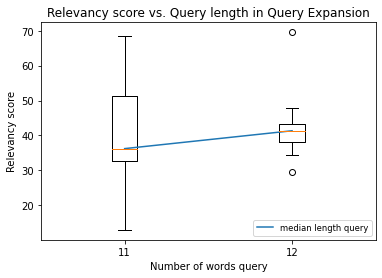

In [228]:
import numpy as np
import statistics

lists = [list(queries[queries['q_length']==idx]['score']) for idx in range(11,13)]

plt.boxplot(lists)

plt.plot(range(1,3), [statistics.median(x) for x in lists], label='median length query')
ax = plt.gca()



plt.title('Relevancy score vs. Query length in Query Expansion')
plt.xlabel('Number of words query')
plt.ylabel('Relevancy score')
plt.legend(loc=4, fontsize='small', fancybox=True)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '11'

labels[1] = '12'

ax.set_xticklabels(labels)

plt.savefig('QueryVsRelvancy_QE.svg')
plt.show()

In [229]:
ordered_df = pd.read_csv("ordered_df.csv")

In [236]:
ordered_df

,ndcg,query,q_length
0,0.728993,what types of food can you cook sous vide,9
1,0.730976,what is the most popular food in switzerland,8
2,0.692343,difference between a mcdouble and a double che...,8
3,0.865154,how to find the midsegment of a trapezoid,8
4,0.463952,what is the daily life of thai people,8
5,0.649552,who formed the commonwealth of independent states,7
6,0.588022,what is durable medical equipment consist of,7
7,0.508563,how long is life cycle of flea,7
8,0.720437,what are the social determinants of health,7
9,0.031054,why did the us volunterilay enter ww1,7


In [242]:
new_pd = queries.merge(ordered_df, left_on='org', right_on='query').drop(columns=['mrr', 'query_x', 'org', 'score'])

In [252]:
ok = new_pd.sort_values(by='q_length_y')

In [308]:
# ok = ok.reset_index()
# ok.shift()[1:]
ok['ndcg_no_qe'] = ok['ndcg_x']
ok['ndcg_qe'] = ok['ndcg_y']

In [326]:
for index, row in ok.iterrows():
    print(row['query_y'], row['ndcg_no_qe'], row['ndcg_qe'])

define visceral 0.24759081674823247 0.6031683036428264
do goldfish grow 0.9352879866023979 0.9304470865926686
rsa definition key 0.6249759424082706 0.8896471212038095
lps laws definition 0.08335160747013295 0.8080444972528796
exons definition biology 0.8928428942493986 0.8206424413246982
definition declaratory judgment 0.8506093714890018 0.8292394276505218
causes of military suicide 0.4206787168451043 0.0163883532847729
right pelvic pain causes 0.3639932490569256 0.3228967954846977
anthropological definition of environment 0.6602899090810109 0.5760110547341993
example of monotonic function 0.8582996215644256 0.6377525486226846
tracheids are part of 0.9000613414602885 0.4262981696655294
who is robert gray 0.4399825306125221 0.4333975354353802
what can contour plowing reduce 0.8859623002427831 0.8311768278288105
what are the three percenters 0.015310661662349513 0.0755977399444353
cost of interior concrete flooring 0.7309118292791024 0.6757374181368075
causes of left ventricular hypertro

In [310]:
ok

,level_0,index,qid,ndcg_x,query_clean,q_length_x,ndcg_y,query_y,q_length_y,ndcg_no_qe,ndcg_qe
0,0,4,1106007,0.247591,defin viscer pariet caviti organ surfac line ...,11,0.603168,define visceral,2,0.247591,0.603168
1,1,20,156493,0.935288,goldfish grow fanci larg common comet inch at...,11,0.930447,do goldfish grow,3,0.935288,0.930447
2,2,33,490595,0.624976,rsa definit kei pair router cisco command gen...,12,0.889647,rsa definition key,3,0.624976,0.889647
3,3,29,443396,0.083352,lp law definit file term liabil allow mean,11,0.808044,lps laws definition,3,0.083352,0.808044
4,4,23,183378,0.892843,exon definit biologi intron gene molecular rn...,11,0.820642,exons definition biology,3,0.892843,0.820642
5,5,17,130510,0.850609,definit declaratori judgment parti court orde...,12,0.829239,definition declaratory judgment,3,0.850609,0.829239
6,6,39,87452,0.420679,caus militari suicid death lead war surpass p...,11,0.016388,causes of military suicide,4,0.420679,0.016388
7,7,32,489204,0.363993,right pelvic pain caus abdomin lower patholog...,11,0.322897,right pelvic pain causes,4,0.363993,0.322897
8,8,24,19335,0.660290,anthropolog definit environ ecolog human theo...,11,0.576011,anthropological definition of environment,4,0.660290,0.576011
9,9,22,182539,0.858300,exampl monoton function domain decreas increa...,11,0.637753,example of monotonic function,4,0.858300,0.637753


In [314]:
for x in ok['ndcg_qe']:
    print(x)

0.6031683036428264
0.9304470865926686
0.8896471212038095
0.8080444972528796
0.8206424413246982
0.8292394276505218
0.0163883532847729
0.3228967954846977
0.5760110547341993
0.6377525486226846
0.4262981696655294
0.4333975354353802
0.8311768278288105
0.0755977399444353
0.6757374181368075
0.6601388687484816
0.4454747349861757
0.5431325079014319
0.9267948834761648
0.8811991369160118
0.3052519542732702
0.5286779625053423
0.3488796259821103
0.6621865048893891
0.3277288753279284
0.7211708414972087
0.4004280085862627
0.8519719390859037
0.6970270336122149
0.5283884041640236
0.5024551918544032
0.6495520042078162
0.0310541725271838
0.5880216915152967
0.720436981699276
0.4960985491766911
0.5085627017260174
0.8651541973155596
0.4639522771419359
0.6923427426398624
0.7309762277436566
0.7289928325613961


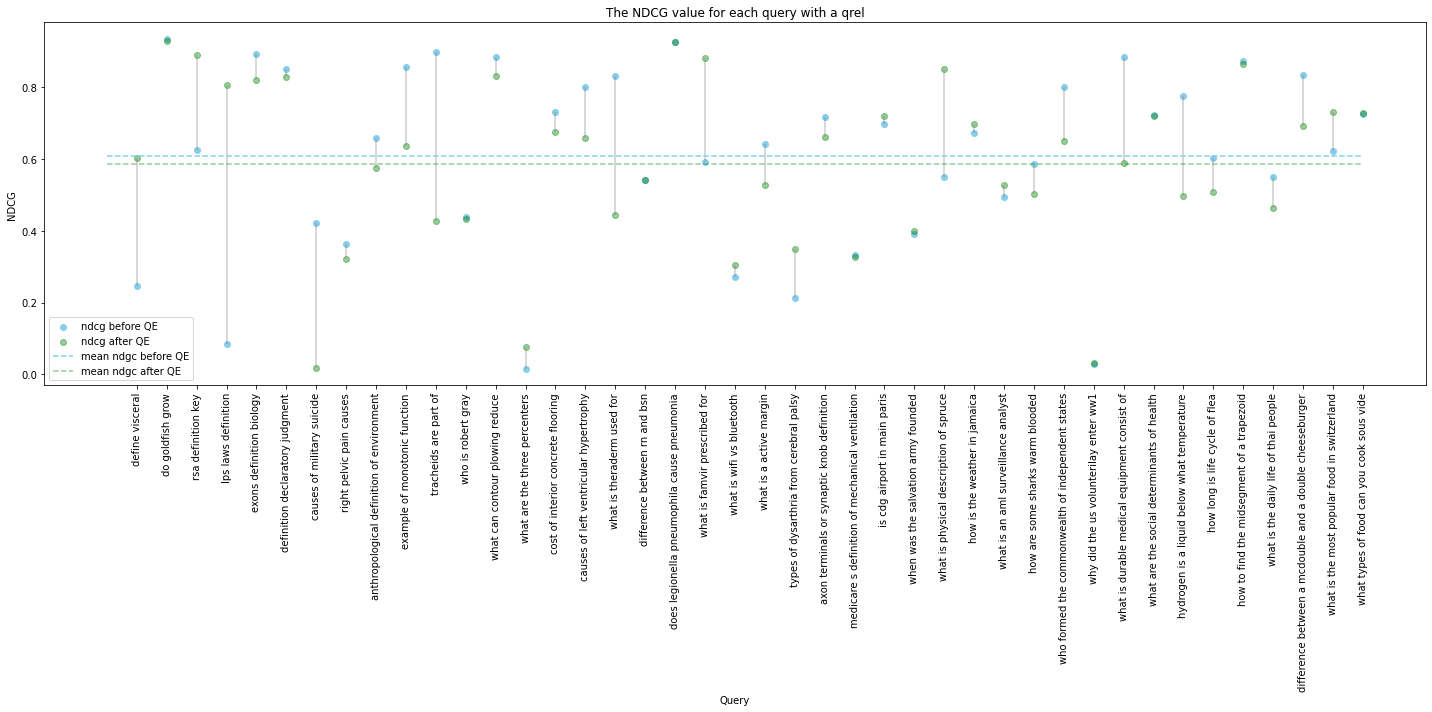

In [333]:
# Reorder it following the values:
my_range=range(1,len(ok.index)+1)

K = 80
space = K
plt.figure(figsize=(20,10))

# The horizontal plot is made using the hline function
# plt.hlines(y=my_range, xmin=0, xmax=ok['ndcg_y'], color='red')
# plt.plot(ok['ndcg_y'], my_range, "o")

# disabling the offset on y axis
ax = plt.gca()
ax.ticklabel_format(useOffset=True)


plt.vlines(x=my_range, ymin=ok['ndcg_y'], ymax=ok['ndcg_x'], color='grey', alpha=0.4)

#x =  result[result["mrr"]<=0.5]["doc_length"], y = result[result["mrr"]<=0.5]["query_length"] 


plt.scatter(my_range, ok['ndcg_no_qe'], color='skyblue', alpha=1, label='ndcg before QE')
plt.scatter(my_range, ok['ndcg_qe'], color='green', alpha=0.4 , label='ndcg after QE')


plt.hlines(xmin=0, xmax=42, y=ok['ndcg_no_qe'].mean(), color='skyblue', alpha=1, linestyles='dashed', label='mean ndgc before QE')
plt.hlines(xmin=0, xmax=42, y=ok['ndcg_qe'].mean(), color='green', alpha=0.4, linestyles='dashed', label='mean ndgc after QE')

plt.legend()
 
# Add titles and axis names
plt.xticks(my_range, ok['query_y'])
plt.title("The NDCG value for each query with a qrel")
plt.ylabel('NDCG')
plt.xlabel('Query')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('QueryVsNDCG_lollipop_QE_Hor.svg')

In [ ]:
# Reorder it following the values:
my_range=range(1,len(ok.index)+1)

K = 80
space = K
plt.figure(figsize=(10,20))

# The horizontal plot is made using the hline function
# plt.hlines(y=my_range, xmin=0, xmax=ok['ndcg_y'], color='red')
# plt.plot(ok['ndcg_y'], my_range, "o")

# disabling the offset on y axis
ax = plt.gca()
ax.ticklabel_format(useOffset=True)


plt.hlines(y=my_range, xmin=ok['ndcg_y'], xmax=ok['ndcg_x'], color='grey', alpha=0.4)

#x =  result[result["mrr"]<=0.5]["doc_length"], y = result[result["mrr"]<=0.5]["query_length"] 


plt.scatter(ok['ndcg_no_qe'], my_range, color='skyblue', alpha=1, label='ndcg before QE')
plt.scatter(ok['ndcg_qe'], my_range, color='green', alpha=0.4 , label='ndcg after QE')


plt.vlines(ok['ndcg_no_qe'].mean(), ymin= 1, ymax = 42, color='skyblue', alpha=1, linestyles='dashed', label='mean ndgc before QE')
plt.vlines(ok['ndcg_qe'].mean(), ymin= 1, ymax = 42, color='green', alpha=0.4, linestyles='dashed', label='mean ndgc after QE')

plt.legend()
 
# Add titles and axis names
plt.yticks(my_range, ok['query_y'])
plt.title("The NDCG value for each query with a qrel")
plt.xlabel('NDCG')
plt.ylabel('Query')
plt.tight_layout()
plt.savefig('QueryVsNDCG_lollipop_QE.svg')